## Domain specific applications

In addition to the default features (array, dataframe, bag etc.) offered by Dask, there are additional domain-specific modules. We are looking at two of them here: machine learning and image processing.

## dask_ml

Just like dask-array is a port of Numpy to Dask, dask_ml is a port from sckit-learn to Dask. Scikit-learn is currently probably the most popular machine-learning package in Python. Dask offers a subset of function available in scikit-learn using the same syntax. Let's see an example. The calculation is **only for the purpose of illustration** and is not realistic.

We look again at the taxi dataset:

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:49550")
client

Client Scheduler: tcp://127.0.0.1:49550 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [2]:
import dask.dataframe as dd

In [24]:
taxi = dd.read_csv('../Data/Chicago_taxi/chicago_taxi_trips_2016_01.csv', dtype={'taxi_id': 'float64'})

In [25]:
taxi

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
npartitions=3,,,,,,,,,,,,,,,,,,,,
,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


We are working here on a trivial question and checking the relation between the fare and the trip time (in seconds). We only keep those two variables:

In [26]:
taxi = taxi[['trip_seconds', 'fare']]

In [27]:
taxi = taxi.dropna()

Then we can easily split out dataset into train and test sets:

In [28]:
train, test = taxi.random_split([0.8, 0.2])

We pick a linear regression model from dask_ml:

In [56]:
from dask_ml.linear_model import LinearRegression

We create a linear fit object as we would do it in scikit-learn:

In [30]:
linfit = LinearRegression(fit_intercept=False)

And we call the ```fit()``` method like for any other scikit-ml method:

In [57]:
linfit_model = linfit.fit(train[['trip_seconds']].values,train[['fare']].values)

We can then predict values for our test set:

In [59]:
pred = linfit_model.predict(test[['trip_seconds']].values)

And we see that the model takes in  dask object and also generates a dask object. Hence we can do prediction for large datasets! Finally we can look at our fit:

(0, 200)

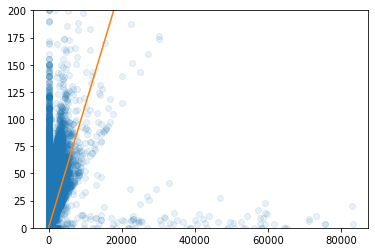

In [61]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
plt.plot(test.trip_seconds.compute().values, test.fare.compute().values,'o',alpha = 0.1)
plt.plot(np.arange(0,20000), linfit_model.coef_[0]*np.arange(0,20000))
ax.set_ylim([0,200])

## dask-image

We have seen before that we could wrap an image importer and other image processing functions into ```delay()``` calls. However Dask offers a built-in set of functions to deal with images. We are going to illistrate this through an example.

We load a series of images:

In [39]:
from dask_image import imread, ndfilters
import dask

We have a series of images in a folder. We want to analyze all of them and create a large dask array:

In [57]:
images = imread.imread('/Users/gw18g940/OneDrive - Universitaet Bern/Courses/DaskCourse/Butterflies/CAM01798*.JPG')

In [58]:
images

dask.array<concatenate, shape=(4, 3456, 5184, 3), dtype=uint8, chunksize=(1, 3456, 5184, 3), chunktype=numpy.ndarray>

Then we only keep a single channel and downscale the image by slicing the array:

In [59]:
im_downscale = images[:,::4,::4,0]

In [61]:
im_downscale

dask.array<getitem, shape=(4, 864, 1296), dtype=uint8, chunksize=(1, 864, 1296), chunktype=numpy.ndarray>

Then we filter each image using a guassian filter implemented in dask-image:

In [62]:
im_filtered = ndfilters.gaussian_filter(im_downscale, sigma=(0,2,2))

We recover both the original and filtere image for comparison. Note that this is not something that one would typically do as it loads all data into RAM:

In [63]:
result = dask.compute(images, im_filtered)

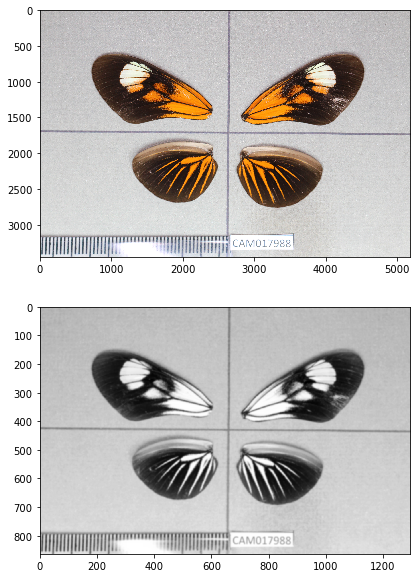

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].imshow(result[0][0,:,:],cmap = 'gray')
ax[1].imshow(result[1][0,:,:],cmap = 'gray')